In [1]:
import sys
from pyprojroot import here as project_root

sys.path.insert(0, str(project_root()))

from fs_mol.data.mat import get_mat_batcher, mat_process_samples
from fs_mol.utils.torch_utils import torchify

from fs_mol.models.mat import MATModel
from fs_mol.models.abstract_torch_fsmol_model import load_model_weights

from bayes_opt.bo_utils import load_antibiotics_dataset, run_gp_ei_bo, min_so_far, task_to_batches
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
task = load_antibiotics_dataset("antibiotics-dataset.xlsx", "../../fs_mol/preprocessing/utils/helper_files/")
mat_samples = mat_process_samples(task.samples)

Skipping datapoint O=C([O-])C=CC(=O)[O-].[Fe+2], cannot featurise with current metadata.
Skipping datapoint CC(O)CN1CCN(CC(=O)[O-])CCN(CC(=O)[O-])CCN(CC(=O)[O-])CC1.[Gd+3], cannot featurise with current metadata.


RDKit ERROR: [02:23:03] UFFTYPER: Unrecognized atom type: Zn1+2 (8)
[02:23:03] UFFTYPER: Unrecognized atom type: Zn1+2 (8)
RDKit ERROR: [02:23:03] UFFTYPER: Unrecognized atom type: Zn1+2 (8)
[02:23:03] UFFTYPER: Unrecognized atom type: Zn1+2 (8)
RDKit ERROR: [02:23:49] UFFTYPER: Unrecognized charge state for atom: 0
[02:23:49] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [02:23:49] UFFTYPER: Unrecognized atom type: Zn+2 (0)
[02:23:49] UFFTYPER: Unrecognized atom type: Zn+2 (0)
RDKit ERROR: [02:23:49] UFFTYPER: Unrecognized charge state for atom: 26
RDKit ERROR: [02:23:49] UFFTYPER: Unrecognized atom type: Zn+2 (26)
[02:23:49] UFFTYPER: Unrecognized charge state for atom: 26
[02:23:49] UFFTYPER: Unrecognized atom type: Zn+2 (26)
RDKit ERROR: [02:23:56] UFFTYPER: Unrecognized charge state for atom: 4
[02:23:56] UFFTYPER: Unrecognized charge state for atom: 4
RDKit ERROR: [02:23:56] UFFTYPER: Unrecognized atom type: Pb3+3 (4)
[02:23:56] UFFTYPER: Unrecognized atom type: Pb

RDKit WARNING: [02:26:13] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [02:26:13] UFFTYPER: Unrecognized charge state for atom: 1
[02:26:13] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[02:26:13] UFFTYPER: Unrecognized charge state for atom: 1
RDKit WARNING: [02:26:13] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[02:26:13] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [02:26:13] UFFTYPER: Unrecognized charge state for atom: 1
[02:26:13] UFFTYPER: Unrecognized charge state for atom: 1
[02:26:13] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit WARNING: [02:26:13] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [02:26:13] UFFTYPER: Unrecognized charge state for atom: 1
[02:26:13] UFFTYPER: Unrecognized charge state for atom: 1
RDKit WARNING: [02:26:13] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[02:26:13] UFFTYPER: Warning: hybridization set to SP3 for atom 1
RDKit ERROR: [02:26

In [3]:
batcher = get_mat_batcher(max_num_graphs=3)
mat_batches = torchify(
    task_to_batches(None, batcher, mat_samples), 
    device=torch.device("cpu")
)

/homes/wc337/FS-Mol-ADKT/third_party/MAT/src/featurization/data_utils.py:270: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/torch/csrc/utils/tensor_new.cpp:201.)
  return [FloatTensor(features) for features in (adjacency_list, features_list, distance_list, labels)]


In [4]:
model_weights_file = "../../../fs-mol-checkpoints/mat_pretrained_weights.pt"

mat_model = MATModel.build_from_model_file(model_weights_file, quiet=True, device=device, config_overrides={"num_tasks": 1})
load_model_weights(mat_model, model_weights_file, load_task_specific_weights=False)

mat_model.eval()

MATModel(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Linear(in_features=1024, out_features=1024, bias=True)
            (2): Linear(in_features=1024, out_features=1024, bias=True)
            (3): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (linears): ModuleList(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (dropout): ModuleList(
            (0): Dropout(p=0.0, inplace=False)
          )
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): SublayerConnection(
            (

In [5]:
representations = []

with torch.no_grad():
    for features in mat_batches:
        node_features = features.node_features.to(device)
        mask = torch.sum(torch.abs(node_features), dim=-1) != 0
        representation = mat_model.encode(node_features, mask, features.adjacency_matrix.to(device), features.distance_matrix.to(device), None)

        mask = mask.unsqueeze(-1).float()
        out_masked = representation * mask
        out_sum = out_masked.sum(dim=1)
        mask_sum = mask.sum(dim=(1))
        out_avg_pooling = out_sum / mask_sum

        representations.append(out_avg_pooling.cpu())
    
del mat_model
torch.cuda.empty_cache()

In [6]:
dataset = task.samples

x_all = torch.cat(representations, dim=0).to(device)
y_all = torch.FloatTensor([float(x.numeric_label) for x in dataset]).to(device)

print(x_all.shape, y_all.shape)

torch.Size([2333, 1024]) torch.Size([2333])


In [7]:
num_init_points = 16
query_batch_size = 1
num_bo_iters = 20
kernel_type = "matern"
init_from = 1600
noise_init = 0.01
noise_prior = True

num_repeats = 20

bo_records = []

In [8]:
for repeat in tqdm(range(num_repeats)):
    bo_record = run_gp_ei_bo(dataset, x_all, y_all, num_init_points, query_batch_size, num_bo_iters, kernel_type, device, init_from, noise_init, noise_prior)
    bo_records.append(min_so_far(bo_record))

100%|███████████████████████████████████████████████████████████████████████████████████████| 20/20 [26:15<00:00, 78.76s/it]


(0.0, 1.5)

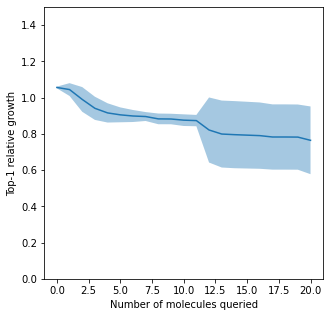

In [9]:
x_axis = np.arange(query_batch_size*num_bo_iters+1)

bo_records = np.array([[y_all[i].item() for i in bo_record] for bo_record in bo_records])
bo_records_mean = bo_records.mean(axis=0)
bo_records_std = bo_records.std(axis=0)

plt.figure(figsize=(5,5))

plt.plot(x_axis, bo_records_mean)
plt.fill_between(x_axis, bo_records_mean-bo_records_std, bo_records_mean+bo_records_std, alpha=0.4)

plt.xlabel("Number of molecules queried")
plt.ylabel("Top-1 relative growth")
plt.ylim(0, 1.5)

In [10]:
import pickle

with open("outputs/mat_bo_records.pkl", "wb") as output_file:
    pickle.dump(bo_records, output_file)